# qbm

## Import Statements

In [1]:
# import external libraries
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
from orderedset import OrderedSet
import os
import scipy.optimize as optimize
import scipy.stats as stats
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
from tqdm.notebook import tqdm

# import internal libraries
from qbm.app_model import AppModel
from qbm.distributions import berry_robnik_pdf, mixed_bernoulli, metropolis_hastings, samples_to_dist
from qbm.gb_qbm import GBQBM
from qbm.qbm import QBM
from qbm.qmc_tim_qbm import QMC_TIM_QBM
from qbm.rbm import RBM
from qbm.restricted_im import RestrictedIM
from qbm.restricted_mxx import RestrictedMXX
from qbm.restricted_tim import RestrictedTIM
from qbm.tim import TIM
from qbm.util import EndEvalHook, EndSaverHook

## Set Simulation Parameters

In [2]:
# set the number of mini-batches per epoch
NUM_MINI_BATCHES = 64

# set the number of epochs
NUM_EPOCHS = 10

# set the number of repetitions
NUM_REPS = 1

# set the learning rate schedule
classical_lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(2e-3, 500, power=0.5)
quantum_lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(2e-3, 500, power=0.5)

# set the Boltzmann machine parameters
# parameters for MNIST from https://github.com/MichelDeudon/RBM-for-MNIST
B_M_PARAMS = [dict(num_visible=6, num_hidden=2, num_ancilla=0,
                   batch_size=32, m_b_p=0.9, m_b_m=8, num_test_samples=512,
                   rbm_optimizer=tf.optimizers.Adam(learning_rate=classical_lr_schedule, beta_1=0.5, beta_2=0.9).get_config(),
                   qbm_optimizer=tf.optimizers.Adam(learning_rate=quantum_lr_schedule, beta_1=0.5, beta_2=0.9).get_config(),
                   qbm_model=TIM, do_ex_qbm=True, do_app_qbm=False, do_qmc_qbm=False)]

# save the parameters
np.save('data/raw_data/params', [NUM_MINI_BATCHES, NUM_EPOCHS, NUM_REPS])
np.save('data/raw_data/B_M_PARAMS', B_M_PARAMS)

# set no GPUs
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

## Test Various Boltzmann Machines

In [3]:
# set the number of training steps
NUM_TRAINS = NUM_MINI_BATCHES * NUM_EPOCHS

# initialize the data
rbm_kl_divs = np.full((len(B_M_PARAMS), NUM_REPS, NUM_TRAINS), np.inf)
rbm_aics = np.full((len(B_M_PARAMS), NUM_REPS, NUM_TRAINS), np.inf)
rbm_params = [[[{} for _ in range(NUM_TRAINS)] for _ in range(NUM_REPS)] for _ in range(len(B_M_PARAMS))]
qbm_kl_divs = np.full((len(B_M_PARAMS), NUM_REPS, NUM_TRAINS), np.inf)
qbm_aics = np.full((len(B_M_PARAMS), NUM_REPS, NUM_TRAINS), np.inf)
app_qbm_kl_divs = np.full((len(B_M_PARAMS), NUM_REPS, NUM_TRAINS), np.inf)
app_qbm_betas = np.zeros((len(B_M_PARAMS), NUM_REPS, NUM_TRAINS))
app_qbm_aics = np.full((len(B_M_PARAMS), NUM_REPS, NUM_TRAINS), np.inf)
app_qbm_eigenenergies = []
qmc_qbm_kl_divs = np.full((len(B_M_PARAMS), NUM_REPS, NUM_TRAINS), np.inf)
qmc_qbm_params = [[[{} for _ in range(NUM_TRAINS)] for _ in range(NUM_REPS)] for _ in range(len(B_M_PARAMS))]

# iterate through all repetitions and Boltzmann machine sizes
for rep in tqdm(iterable=range(NUM_REPS), desc='Repetition'):
    for param_index, params in enumerate(tqdm(iterable=B_M_PARAMS, desc='Parameters')):
        # set the qubits
        num_qbm_qubits = params['num_visible'] + params['num_hidden']
        num_total_qubits = num_qbm_qubits + params['num_ancilla']
        visible_qubits = OrderedSet(range(params['num_visible']))
        hidden_qubits = OrderedSet(range(params['num_visible'], num_qbm_qubits))
        ancilla_qubits = OrderedSet(range(num_qbm_qubits, num_total_qubits))

        # generate data
        distribution = mixed_bernoulli(params['m_b_p'], params['m_b_m'], params['num_visible'])
        train_data = np.array([metropolis_hastings(distribution, params['num_visible'])
                               for _ in tqdm(iterable=range(NUM_MINI_BATCHES*params['batch_size']),
                                             desc='Training data')],
                              dtype=np.float32)
        test_data = np.array([metropolis_hastings(distribution, params['num_visible'])
                              for _ in tqdm(iterable=range(params['num_test_samples']), desc='Testing data')],
                             dtype=np.float32)
        test_distribution = samples_to_dist(test_data)

        # set the initial biases
        initial_bias_probs = (1-np.zeros_like(train_data[0])) / 2#(1-np.mean(train_data, axis=0)) / 2
        initial_params = {}
        if 'initial_gamma_mean' in params:
            initial_params['gammas'] = np.random.normal(loc=params['initial_gamma_mean'], scale=0.005,
                                                        size=num_qbm_qubits).astype(np.float32)
        initial_params['biases'] = np.concatenate((np.log((0.001+initial_bias_probs)/(1.001-initial_bias_probs)),
                                                   np.random.normal(scale=0.005, size=len(hidden_qubits)))).astype(
            np.float32)

        # save the generated samples
        np.save('data/raw_data/train_data_{}_{}'.format(param_index, rep), train_data)
        np.save('data/raw_data/test_data_{}_{}'.format(param_index, rep), test_data)

        # create the various graphs
        rbm_graph = tf.Graph()
        qbm_graph = tf.Graph()
        app_qbm_graph = tf.Graph()
        qmc_qbm_graph = tf.Graph()

        # set the RBM graph as default
        with rbm_graph.as_default():
            # create the RBM
            rbm = RBM(visible_qubits, hidden_qubits, initial_params=initial_params)

            # generate the necessary RBM tensors
            rbm_mini_batches = RBM.mini_batch_generator(train_data, NUM_EPOCHS,
                                                        batch_size=params['batch_size'])
            rbm_train_op = rbm.train_op(rbm_mini_batches, tf.optimizers.Adam.from_config(params['rbm_optimizer']))
            with tf.control_dependencies([rbm_train_op]):
                rbm_random_samples = rbm.random_samples(num_samples=params['num_test_samples'])
            num_rbm_params = sum([np.prod(rbm.params[param].get_shape().as_list()) for param in rbm.params])

            # create a saver and a hook for the RBM
            rbm_saver_hook = EndSaverHook('data/models/rbm_model_{}_{}.ckpt'.format(param_index, rep))

            # train the RBM
            with tf.compat.v1.train.MonitoredTrainingSession(hooks=[rbm_saver_hook]) as sess:
                with tqdm(desc='RBM mini-batch', total=NUM_TRAINS) as pbar:
                    for mini_batch_index in range(NUM_TRAINS):
                        _, random_samples = sess.run([rbm_train_op, rbm_random_samples])
                        sample_dist = samples_to_dist(random_samples[:, :params['num_visible']])
                        rbm_kl_divs[param_index, rep, mini_batch_index] = stats.entropy(sample_dist,
                                                                                        test_distribution)
#                         rbm_aics[param_index, rep, mini_batch_index] = 2 * (num_rbm_params
#                                                                             -np.dot(test_distribution,
#                                                                                     np.log(sample_dist)))
                        rbm_aics[param_index, rep, mini_batch_index] = stats.entropy(test_distribution,
                                                                                     sample_dist)
                        rbm_params[param_index][rep][mini_batch_index] = sess.run(rbm.params)
                        pbar.update()

        # save the RBM data
        np.save('data/raw_data/rbm_kl_divs', rbm_kl_divs)
        np.save('data/raw_data/rbm_aics', rbm_aics)
        np.save('data/raw_data/rbm_params', rbm_params)

        # if appropriate, set the QBM graph as default
        if not 'do_ex_qbm' in params or params['do_ex_qbm']:
            with qbm_graph.as_default():
                # create the QBM model
                qbm_model = params['qbm_model'](visible_qubits, hidden_qubits, initial_params=initial_params)

                # create the gradient-based QBM
                qbm = GBQBM(qbm_model)

                # generate the necessary QBM tensors
                qbm_mini_batches = GBQBM.mini_batch_generator(train_data, NUM_EPOCHS,
                                                              batch_size=params['batch_size'])
                qbm_train_op = qbm.train_op(qbm_mini_batches, tf.optimizers.Adam.from_config(params['qbm_optimizer']))
                with tf.control_dependencies([qbm_train_op]):
                    qbm_random_samples = qbm.random_samples(num_samples=params['num_test_samples'])
                    num_qbm_params = sum([np.prod(param.get_shape().as_list()) for param in qbm.model.variable_params])

                # create a saver and a hook for the QBM
                qbm_saver_hook = EndSaverHook('data/models/qbm_model_{}_{}.ckpt'.format(param_index, rep))

                # train the QBM
                with tf.compat.v1.train.MonitoredTrainingSession(hooks=[qbm_saver_hook]) as sess:
                    with tqdm(desc='QBM mini-batch', total=NUM_TRAINS) as pbar:
                        for mini_batch_index in range(NUM_TRAINS):
                            _, random_samples = sess.run([qbm_train_op, qbm_random_samples])
                            sample_dist = samples_to_dist(random_samples[:, :params['num_visible']])
                            qbm_kl_divs[param_index, rep, mini_batch_index] = stats.entropy(sample_dist,
                                                                                            test_distribution)
#                             qbm_aics[param_index, rep, mini_batch_index] = 2 * (num_qbm_params
#                                                                                 -np.dot(test_distribution,
#                                                                                         np.log(sample_dist)))
                            qbm_aics[param_index, rep, mini_batch_index] = stats.entropy(test_distribution,
                                                                                         sample_dist)
                            pbar.update()

            # save the QBM data
            np.save('data/raw_data/qbm_kl_divs', qbm_kl_divs)
            np.save('data/raw_data/qbm_aics', qbm_aics)

        # if appropriate, set the approximate QBM graph as default
        if not 'do_app_qbm' in params or params['do_app_qbm']:
            with app_qbm_graph.as_default():
                # set the QBM model
                with tf.compat.v1.variable_scope('qbm_model'):
                    app_qbm_qbm_model = params['qbm_model'](visible_qubits, hidden_qubits,
                                                            ancilla_qubits=ancilla_qubits,
                                                            initial_params=initial_params)

                # set the thermometer model
                with tf.compat.v1.variable_scope('therm_model'):
                    app_qbm_therm_model = params['qbm_model'](ancilla_qubits, OrderedSet(),
                                                              ancilla_qubits=visible_qubits|hidden_qubits)

                # create the approximate QBM model
                app_qbm_model = AppModel(app_qbm_qbm_model, app_qbm_therm_model,
                                         noise_params=params['noise_params'])

                # create the gradient-based approximate QBM
                app_qbm = GBQBM(app_qbm_model)

                # generate the necessary approximate QBM tensors
                app_qbm_mini_batches = GBQBM.mini_batch_generator(train_data, NUM_EPOCHS,
                                                                  batch_size=params['batch_size'])
                app_qbm_train_op = app_qbm.train_op(app_qbm_mini_batches, tf.optimizers.Adam.from_config(params['app_qbm_optimizer']))
                with tf.control_dependencies([app_qbm_train_op]):
                    app_qbm_random_samples = app_qbm.random_samples(num_samples=params['num_test_samples'])
                num_app_qbm_params = sum([np.prod(param.get_shape().as_list())
                                          for param in app_qbm.model.variable_params])
                if 'find_eigenenergies' in params and params['find_eigenenergies']:
                    app_qbm_eigenenergy_tensor, _ = tf.linalg.eigh(app_qbm_model.hamiltonian)

                # create a saver and a hook for the approximate QBM
                app_qbm_saver_hook = EndSaverHook('data/models/app_qbm_model_{}_{}.ckpt'.format(param_index, rep))
                app_qbm_hooks = [app_qbm_saver_hook]
                if 'find_eigenenergies' in params and params['find_eigenenergies']:
                    app_qbm_eigenenergies_hook = EndEvalHook(app_qbm_eigenenergy_tensor)
                    app_qbm_hooks.append(app_qbm_eigenenergies_hook)

                # train the approximate QBM
                with tf.compat.v1.train.MonitoredTrainingSession(hooks=app_qbm_hooks) as sess:
                    with tqdm(desc='Approximate QBM mini-batch', total=NUM_TRAINS) as pbar:
                        for mini_batch_index in range(NUM_TRAINS):
                            _, random_samples = sess.run([app_qbm_train_op, app_qbm_random_samples])
                            sample_dist = samples_to_dist(random_samples[:, :params['num_visible']])
                            app_qbm_kl_divs[param_index, rep, mini_batch_index] = stats.entropy(sample_dist,
                                                                                                test_distribution)
                            app_qbm_betas[param_index, rep, mini_batch_index] = sess.run(app_qbm.model.beta)
                            app_qbm_aics[param_index, rep, mini_batch_index] = 2 * (num_app_qbm_params
                                                                                    -np.dot(test_distribution,
                                                                                            np.log(sample_dist)))
                            pbar.update()

            # save the approximate QBM data
            np.save('data/raw_data/app_qbm_kl_divs', app_qbm_kl_divs)
            np.save('data/raw_data/app_qbm_betas', app_qbm_betas)
            np.save('data/raw_data/app_qbm_aics', app_qbm_aics)
            if 'find_eigenenergies' in params and params['find_eigenenergies']:
                app_qbm_eigenenergies.append(app_qbm_eigenenergies_hook.eval_result)
            np.save('data/raw_data/app_qbm_eigenenergies', app_qbm_eigenenergies)

        # set the QMC QBM graph as default
        if not 'do_qmc_qbm' in params or params['do_qmc_qbm']:
            with qmc_qbm_graph.as_default():
                # create the QMC QBM
                qmc_qbm = QMC_TIM_QBM(visible_qubits, hidden_qubits, initial_params=initial_params)

                # generate the necessary QMC QBM tensors
                qmc_qbm_mini_batches = QMC_TIM_QBM.mini_batch_generator(train_data, NUM_EPOCHS,
                                                                        batch_size=params['batch_size'])
                qmc_qbm_train_op = qmc_qbm.train_op(qmc_qbm_mini_batches, tf.optimizers.Adam.from_config(params['qbm_optimizer']))
                with tf.control_dependencies([qmc_qbm_train_op]):
                    qmc_qbm_random_samples = qmc_qbm.random_samples(num_samples=params['num_test_samples'])

                # create a saver and a hook for the QMC QBM
                qmc_qbm_saver_hook = EndSaverHook('data/models/qmc_qbm_model_{}_{}.ckpt'.format(param_index, rep))

                # train the QMC QBM
                with tf.compat.v1.train.MonitoredTrainingSession(hooks=[qmc_qbm_saver_hook]) as sess:
                    with tqdm(desc='QMC QBM mini-batch', total=NUM_TRAINS) as pbar:
                        for mini_batch_index in range(NUM_TRAINS):
                            _, random_samples = sess.run([qmc_qbm_train_op, qmc_qbm_random_samples])
                            sample_dist = samples_to_dist(random_samples[:, :params['num_visible']])
                            qmc_qbm_kl_divs[param_index, rep, mini_batch_index] = stats.entropy(sample_dist,
                                                                                                test_distribution)
                            qmc_qbm_params[param_index][rep][mini_batch_index] = sess.run(qmc_qbm.params)
                            pbar.update()

            # save the QBM data
            np.save('data/raw_data/qmc_qbm_kl_divs', qmc_qbm_kl_divs)
            np.save('data/raw_data/qmc_qbm_params', qmc_qbm_params)

Repetition:   0%|          | 0/1 [00:00<?, ?it/s]

Parameters:   0%|          | 0/1 [00:00<?, ?it/s]

Training data:   0%|          | 0/2048 [00:00<?, ?it/s]

Testing data:   0%|          | 0/512 [00:00<?, ?it/s]

INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


RBM mini-batch:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


QBM mini-batch:   0%|          | 0/640 [00:00<?, ?it/s]

## Reload the Data

In [4]:
# set the maximum plot range ratio
MAX_PLOT_RANGE_RATIO = 67

# set the eigenenergy plot precision
EIGENENERGY_PLOT_PRECISION = 500

# reload the data
NUM_MINI_BATCHES, NUM_EPOCHS, NUM_REPS = np.load('data/raw_data/params.npy')
B_M_PARAMS = np.load('data/raw_data/B_M_PARAMS.npy', allow_pickle=True)
rbm_kl_divs = np.load('data/raw_data/rbm_kl_divs.npy')
rbm_aics = np.load('data/raw_data/rbm_aics.npy')
# rbm_params = np.load('data/raw_data/rbm_params.npy', allow_pickle=True)
# qbm_kl_divs = np.load('data/raw_data/qbm_kl_divs.npy')
# qbm_aics = np.load('data/raw_data/qbm_aics.npy')
# app_qbm_kl_divs = np.load('data/raw_data/app_qbm_kl_divs.npy')
# app_qbm_betas = np.load('data/raw_data/app_qbm_betas.npy')
# app_qbm_aics = np.load('data/raw_data/app_qbm_aics.npy')
# app_qbm_eigenenergies = np.load('data/raw_data/app_qbm_eigenenergies.npy')
# qmc_qbm_kl_divs = np.load('data/raw_data/qmc_qbm_kl_divs.npy')
# qmc_qbm_params = np.load('data/raw_data/qmc_qbm_params.npy', allow_pickle=True)

# reset relevant parameters
NUM_TRAINS = NUM_MINI_BATCHES * NUM_EPOCHS

## Analyze the Data

/home/eanschuetz/.conda/envs/qi/lib/python3.8/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


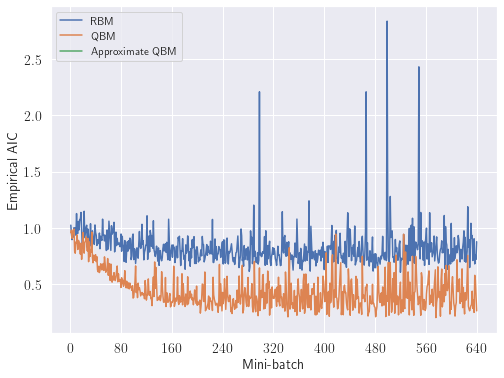

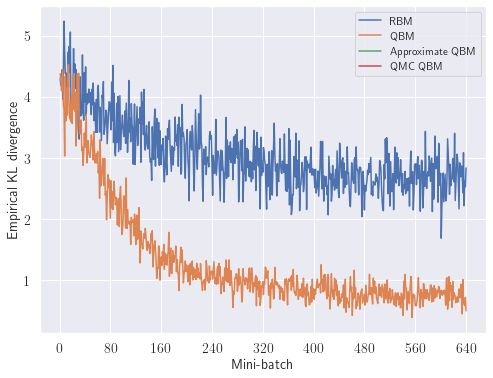

/home/eanschuetz/.conda/envs/qi/lib/python3.8/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


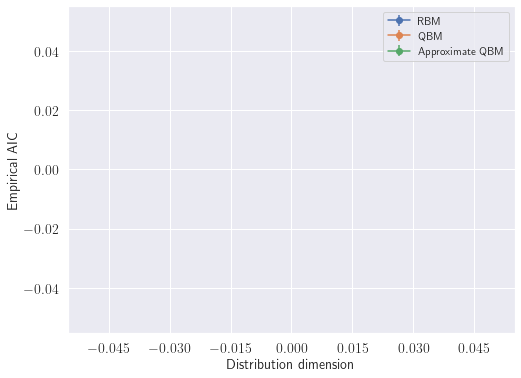

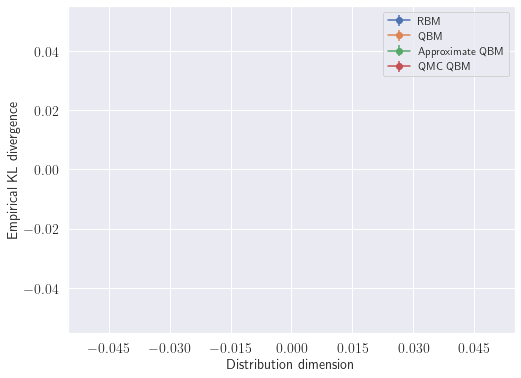

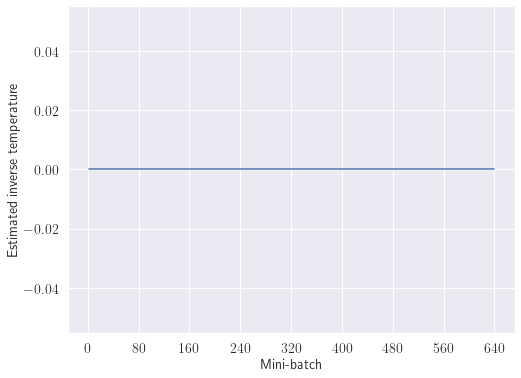

AxisError: axis 1 is out of bounds for array of dimension 1

In [5]:
# set the plot text to TeX mode
sns.set()
matplotlib.rc('text', usetex=True)

# set the errorbars to use caps
matplotlib.rcParams.update({'errorbar.capsize': 2})

# iterate through all sets of parameters
for i in range(len(B_M_PARAMS)):
    # generate the final parameters setting training performances
    rbm_aics_final_mean = np.mean(rbm_aics[i], axis=0)
    rbm_aics_final_std = np.std(rbm_aics[i], axis=0)
    qbm_aics_final_mean = np.mean(qbm_aics[i], axis=0)
    qbm_aics_final_std = np.std(qbm_aics[i], axis=0)
    app_qbm_aics_final_mean = np.mean(app_qbm_aics[i], axis=0)
    app_qbm_aics_final_std = np.std(app_qbm_aics[i], axis=0)
    rbm_kl_divs_final_mean = np.mean(rbm_kl_divs[i], axis=0)
    rbm_kl_divs_final_std = np.std(rbm_kl_divs[i], axis=0)
    qbm_kl_divs_final_mean = np.mean(qbm_kl_divs[i], axis=0)
    qbm_kl_divs_final_std = np.std(qbm_kl_divs[i], axis=0)
    app_qbm_kl_divs_final_mean = np.mean(app_qbm_kl_divs[i], axis=0)
    app_qbm_kl_divs_final_std = np.std(app_qbm_kl_divs[i], axis=0)
    qmc_qbm_kl_divs_final_mean = np.mean(qmc_qbm_kl_divs[i], axis=0)
    qmc_qbm_kl_divs_final_std = np.std(qmc_qbm_kl_divs[i], axis=0)

    # plot the final parameters setting training performances
    plt.plot(range(1, NUM_TRAINS+1), rbm_aics_final_mean, label='RBM')
    plt.fill_between(range(1, NUM_TRAINS+1), rbm_aics_final_mean-rbm_aics_final_std,
                     y2=rbm_aics_final_mean+rbm_aics_final_std, alpha=0.5)
    plt.plot(range(1, NUM_TRAINS+1), qbm_aics_final_mean, label='QBM')
    plt.fill_between(range(1, NUM_TRAINS+1), qbm_aics_final_mean-qbm_aics_final_std,
                     y2=qbm_aics_final_mean+qbm_aics_final_std, alpha=0.5)
    plt.plot(range(1, NUM_TRAINS+1), app_qbm_aics_final_mean, label='Approximate QBM')
    plt.fill_between(range(1, NUM_TRAINS+1), app_qbm_aics_final_mean-app_qbm_aics_final_std,
                     y2=app_qbm_aics_final_mean+app_qbm_aics_final_std, alpha=0.5)
    plt.xlabel('Mini-batch', fontsize=14)
    plt.ylabel('Empirical AIC', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.gcf().set_size_inches(8, 6)
    plt.gcf().savefig('data/plots/aics_mini_batch_{}.pdf'.format(i), bbox_inches='tight')
    plt.show()
    plt.plot(range(1, NUM_TRAINS+1), rbm_kl_divs_final_mean, label='RBM')
    plt.fill_between(range(1, NUM_TRAINS+1), rbm_kl_divs_final_mean-rbm_kl_divs_final_std,
                     y2=rbm_kl_divs_final_mean+rbm_kl_divs_final_std, alpha=0.5)
    plt.plot(range(1, NUM_TRAINS+1), qbm_kl_divs_final_mean, label='QBM')
    plt.fill_between(range(1, NUM_TRAINS+1), qbm_kl_divs_final_mean-qbm_kl_divs_final_std,
                     y2=qbm_kl_divs_final_mean+qbm_kl_divs_final_std, alpha=0.5)
    plt.plot(range(1, NUM_TRAINS+1), app_qbm_kl_divs_final_mean, label='Approximate QBM')
    plt.fill_between(range(1, NUM_TRAINS+1), app_qbm_kl_divs_final_mean-app_qbm_kl_divs_final_std,
                     y2=app_qbm_kl_divs_final_mean+app_qbm_kl_divs_final_std, alpha=0.5)
    plt.plot(range(1, NUM_TRAINS+1), qmc_qbm_kl_divs_final_mean, label='QMC QBM')
    plt.fill_between(range(1, NUM_TRAINS+1), qmc_qbm_kl_divs_final_mean-qmc_qbm_kl_divs_final_std,
                     y2=qmc_qbm_kl_divs_final_mean+qmc_qbm_kl_divs_final_std, alpha=0.5)
    plt.xlabel('Mini-batch', fontsize=14)
    plt.ylabel('Empirical KL divergence', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.gcf().set_size_inches(8, 6)
    plt.gcf().savefig('data/plots/kl_divs_mini_batch_{}.pdf'.format(i), bbox_inches='tight')
    plt.show()

# generate the final training performance as a function of parameters
rbm_min_aics_mean = np.mean(rbm_aics.min(axis=2), axis=1)
rbm_min_aics_std = np.std(rbm_aics.min(axis=2), axis=1)
qbm_min_aics_mean = np.mean(qbm_aics.min(axis=2), axis=1)
qbm_min_aics_std = np.std(qbm_aics.min(axis=2), axis=1)
app_qbm_min_aics_mean = np.mean(app_qbm_aics.min(axis=2), axis=1)
app_qbm_min_aics_std = np.std(app_qbm_aics.min(axis=2), axis=1)
rbm_min_kl_divs_mean = np.mean(rbm_kl_divs.min(axis=2), axis=1)
rbm_min_kl_divs_std = np.std(rbm_kl_divs.min(axis=2), axis=1)
qbm_min_kl_divs_mean = np.mean(qbm_kl_divs.min(axis=2), axis=1)
qbm_min_kl_divs_std = np.std(qbm_kl_divs.min(axis=2), axis=1)
app_qbm_min_kl_divs_mean = np.mean(app_qbm_kl_divs.min(axis=2), axis=1)
app_qbm_min_kl_divs_std = np.std(app_qbm_kl_divs.min(axis=2), axis=1)
qmc_qbm_min_kl_divs_mean = np.mean(qmc_qbm_kl_divs.min(axis=2), axis=1)
qmc_qbm_min_kl_divs_std = np.std(qmc_qbm_kl_divs.min(axis=2), axis=1)

# generate the abscissa for the final training performance as a function of parameters
num_visibles = []
rbm_min_aics_mean_to_plot = []
rbm_min_aics_std_to_plot = []
qbm_min_aics_mean_to_plot = []
qbm_min_aics_std_to_plot = []
app_qbm_min_aics_mean_to_plot = []
app_qbm_min_aics_std_to_plot = []
rbm_min_kl_divs_mean_to_plot = []
rbm_min_kl_divs_std_to_plot = []
qbm_min_kl_divs_mean_to_plot = []
qbm_min_kl_divs_std_to_plot = []
app_qbm_min_kl_divs_mean_to_plot = []
app_qbm_min_kl_divs_std_to_plot = []
qmc_qbm_min_kl_divs_mean_to_plot = []
qmc_qbm_min_kl_divs_std_to_plot = []
for i in range(len(B_M_PARAMS)):
    if B_M_PARAMS[i]['num_hidden'] == 1:
        num_visibles.append(B_M_PARAMS[i]['num_visible'])
        rbm_min_aics_mean_to_plot.append(rbm_min_aics_mean[i])
        rbm_min_aics_std_to_plot.append(rbm_min_aics_std[i])
        qbm_min_aics_mean_to_plot.append(qbm_min_aics_mean[i])
        qbm_min_aics_std_to_plot.append(qbm_min_aics_std[i])
        app_qbm_min_aics_mean_to_plot.append(app_qbm_min_aics_mean[i])
        app_qbm_min_aics_std_to_plot.append(app_qbm_min_aics_std[i])
        rbm_min_kl_divs_mean_to_plot.append(rbm_min_kl_divs_mean[i])
        rbm_min_kl_divs_std_to_plot.append(rbm_min_kl_divs_std[i])
        qbm_min_kl_divs_mean_to_plot.append(qbm_min_kl_divs_mean[i])
        qbm_min_kl_divs_std_to_plot.append(qbm_min_kl_divs_std[i])
        app_qbm_min_kl_divs_mean_to_plot.append(app_qbm_min_kl_divs_mean[i])
        app_qbm_min_kl_divs_std_to_plot.append(app_qbm_min_kl_divs_std[i])
        qmc_qbm_min_kl_divs_mean_to_plot.append(qmc_qbm_min_kl_divs_mean[i])
        qmc_qbm_min_kl_divs_std_to_plot.append(qmc_qbm_min_kl_divs_std[i])

# plot the final training performance as a function of parameters
plt.errorbar(num_visibles, rbm_min_aics_mean_to_plot, yerr=rbm_min_aics_std_to_plot, fmt='-o', label='RBM')
plt.errorbar(num_visibles, qbm_min_aics_mean_to_plot, yerr=qbm_min_aics_std_to_plot, fmt='-o', label='QBM')
plt.errorbar(num_visibles, app_qbm_min_aics_mean_to_plot, yerr=app_qbm_min_aics_std_to_plot, fmt='-o',
             label='Approximate QBM')
plt.xlabel('Distribution dimension', fontsize=14)
plt.ylabel('Empirical AIC', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.gcf().set_size_inches(8, 6)
plt.gcf().savefig('data/plots/aics_size.pdf', bbox_inches='tight')
plt.show()
plt.errorbar(num_visibles, rbm_min_kl_divs_mean_to_plot, yerr=rbm_min_kl_divs_std_to_plot, fmt='-o', label='RBM')
plt.errorbar(num_visibles, qbm_min_kl_divs_mean_to_plot, yerr=qbm_min_kl_divs_std_to_plot, fmt='-o', label='QBM')
plt.errorbar(num_visibles, app_qbm_min_kl_divs_mean_to_plot, yerr=app_qbm_min_kl_divs_std_to_plot, fmt='-o',
             label='Approximate QBM')
plt.errorbar(num_visibles, qmc_qbm_min_kl_divs_mean_to_plot, yerr=qmc_qbm_min_kl_divs_std_to_plot, fmt='-o',
             label='QMC QBM')
plt.xlabel('Distribution dimension', fontsize=14)
plt.ylabel('Empirical KL divergence', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.gcf().set_size_inches(8, 6)
plt.gcf().savefig('data/plots/kl_divs_size.pdf', bbox_inches='tight')
plt.show()

# generate the estimated inverse temperatures
app_qbm_betas_mean = np.mean(app_qbm_betas, axis=1)
app_qbm_betas_std = np.std(app_qbm_betas, axis=1)

# plot the estimated inverse temperatures
plt.plot(range(1, NUM_TRAINS+1), app_qbm_betas_mean[-1], label=len(B_M_PARAMS))
plt.fill_between(range(1, NUM_TRAINS+1), app_qbm_betas_mean[-1]-app_qbm_betas_std[-1],
                 y2=app_qbm_betas_mean[-1]+app_qbm_betas_std[-1], alpha=0.5)
plt.xlabel('Mini-batch', fontsize=14)
plt.ylabel('Estimated inverse temperature', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.gcf().set_size_inches(8, 6)
plt.gcf().savefig('data/plots/betas.pdf', bbox_inches='tight')
plt.show()

# find the mean tranverse fields
gamma_over_w_ints = []
for rep in range(NUM_REPS):
    for i, params in enumerate(B_M_PARAMS):
        if 'find_eigenenergies' in params and params['find_eigenenergies']:
            if 'initial_gamma_mean' in params:
                gamma_over_w_ints.append(params['initial_gamma_mean'])

# calculate the level spacings
level_spacings = [[app_qbm_eigenenergies[i][j+1]-app_qbm_eigenenergies[i][j]
                   for j in range(len(app_qbm_eigenenergies[i])-1)] for i in range(len(app_qbm_eigenenergies))]
median_level_spacings = np.median(level_spacings, axis=1)
normalized_level_spacings = np.array([level_spacings[i]/median_level_spacings[i]
                                      for i in range(len(level_spacings))])
min_plot = np.min(normalized_level_spacings)
max_plot = np.max(normalized_level_spacings) / MAX_PLOT_RANGE_RATIO
plot_range = np.arange(min_plot, max_plot, (max_plot-min_plot)/EIGENENERGY_PLOT_PRECISION)
truncated_normalized_level_spacings = []
for mean_gamma_nls in normalized_level_spacings:
    truncated_normalized_level_spacings.append([])
    for normalized_level_spacing in mean_gamma_nls:
        if normalized_level_spacing < max_plot:
            truncated_normalized_level_spacings[-1].append(normalized_level_spacing)

# plot the final level spacings with a fitted Berry--Robnik distribution
histograms = []
for i in range(len(truncated_normalized_level_spacings)):
    histogram = np.histogram(truncated_normalized_level_spacings[i], bins=EIGENENERGY_PLOT_PRECISION, density=True)
    histograms.append([histogram[0], histogram[1][:-1]])
histograms = np.array(histograms, dtype=np.float64)
curve_fits = []
for i in range(len(histograms)):
    curve_fits.append(optimize.curve_fit(berry_robnik_pdf, histograms[i][1], histograms[i][0],
                                         p0=0.5, bounds=(0, 1))[0][0])
for i in range(len(histograms)):
    plt.hist(truncated_normalized_level_spacings[i], bins=EIGENENERGY_PLOT_PRECISION, density=True,
             label='$\overline{{\mathit{{\Gamma}}}}/\sqrt{{\overline{{w_{{\mathrm{{int}}}}^2}}}}={:.4f}$'.format(
                 gamma_over_w_ints[i]))
    plt.plot(plot_range, berry_robnik_pdf(plot_range, curve_fits[i]),
             label='$\\rho\\approx {:.4f}'.format(curve_fits[i])+'$')
    plt.xlabel('Level spacing per median level spacing', fontsize=14)
    plt.ylabel('Probability', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.gcf().set_size_inches(8, 6)
    plt.gcf().savefig('data/plots/app_qbm_level_spacings_{}.pdf'.format(i), bbox_inches='tight')
    plt.show()

# plot the fitted rho as a function of the transverse field
curve_fits_dict = {}
for i, gamma_over_w_int in enumerate(gamma_over_w_ints):
    if gamma_over_w_int not in curve_fits_dict:
        curve_fits_dict[gamma_over_w_int] = [curve_fits[i]]
    else:
        curve_fits_dict[gamma_over_w_int].append(curve_fits[i])
curve_fit_xs = list(curve_fits_dict.keys())
curve_fit_ys = list(curve_fits_dict.values())
curve_fit_y_means = np.mean(curve_fit_ys, axis=1)
curve_fit_y_stds = np.std(curve_fit_ys, axis=1)
plt.errorbar(curve_fit_xs, curve_fit_y_means, yerr=curve_fit_y_stds, fmt='o-')
plt.xlabel('$\overline{\mathit{\Gamma}}/\sqrt{\overline{w_{\mathrm{int}}^2}}$', fontsize=14)
plt.ylabel('$\\rho$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gcf().set_size_inches(8, 6)
plt.gcf().savefig('data/plots/app_qbm_level_spacing_gamma_rho.pdf', bbox_inches='tight')
plt.show()